# Transformer Teardown: DistilBERT

> Tracing an inference from raw data to prediction

<img src="banner-circuit-trail.png" class="stickshift-figure" width="800">

I loved taking things apart as a kid. Especially discarded electronics. I used to keep a pile of the circuit boards I scavenged in my closet. If I stacked them together the right way, I was convinced I could build my own C-3PO.

As an adult, I still like taking things apart. Methodically dissecting, cataloging, and rebuilding helps me wrap my brain around new technology. Especially the hardcore stuff like LLMs and the Transformers that power them.

While there are a million papers, blogs, and tutorials written on Transformers, I still find it challenging to map the abstract ideas from the research literature into concrete, actionable steps you can experiment with. My engineer's brain wants to "see the code" behind high level concepts like embeddings, residuals, and multi-head self-attention. Yes, it's easy to find open source Transformer implementations, but they're often overloaded with configuration settings to the point that the main ideas are completely obscured.

The goal of this post is to give you a stronger sense of the Transformer machinery powering the AI revolution. We'll dissect Hugging Face's default text-classification model, lay all the pieces on the table, and then trace a single inference through the stack from raw data to final prediction. We'll illustrate the main ideas from the Transformer literature with minimal, straightforward, working Python code. You may be surprised by how few steps are required!

All of the code for this post is available in [GitHub](https://github.com/stickshift/stickshift.github.io/blob/main/posts/2024-09-04-transformer-teardown/2024-09-04-transformer-teardown.ipynb) but it's a lot easier to [read with nbviewer](https://nbviewer.org/github/stickshift/stickshift.github.io/blob/main/posts/2024-09-04-transformer-teardown/2024-09-04-transformer-teardown.ipynb)!

# Setup

In [1]:
import warnings

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from pytest import approx
import torch
from torch import nn
from torch.nn.functional import relu, softmax
import transformers

from stickshift import default_arg, take
from stickshift.models import distilbert

In [2]:
# Ignore all warnings
warnings.filterwarnings("ignore")

# Configure gpu
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

# Text Classification with DistilBERT

If you've worked with Transformers at all, I'm sure you're familiar with Hugging Face's collection of Python libraries as well as their endless repository of models and datasets. Throughout the post, we'll be working with Hugging Face's default text classification model DistilBERT. DistilBERT is a smaller, faster, lighter-weight version of the original BERT model that's easier to experiment with. We'll use the pre-trained model parameters from Hugging Face, but we'll implement the model's logic step-by-step in Jupyter using a slightly modified version of the actual DistilBERT PyTorch implementation from Hugging Face's `transformers` library.

Before we get into the implementation, let's start by running the entire process end-to-end using Hugging Face's high level `pipeline` API. The following cells create a complete text classification pipeline and then apply it to the sentence "I love ice cream". As you might expect, the model classifies the sentence as overwhelmingly positive. Over the rest of the post, we'll break this prediction down and recreate it one step at a time.

In [3]:
# Create off-the-shelf text classification transformer
transformer = transformers.pipeline("text-classification", device=device)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [4]:
transformer("I love ice cream")

[{'label': 'POSITIVE', 'score': 0.9998118281364441}]

In [5]:
# Load model config and pre-trained parameters
config = distilbert.config(transformer.model)
parameters = transformer.model.state_dict()

In [6]:
def load_state(*args, layer=None):
    # Defaults
    layer = default_arg(layer, lambda: 0)

    for module, key in take(2, args):
        match key:
            case "value_embeddings":
                module.load_state_dict({
                    "weight": parameters["distilbert.embeddings.word_embeddings.weight"],
                })
            case "position_embeddings":
                module.load_state_dict({
                    "weight": parameters["distilbert.embeddings.position_embeddings.weight"],
                })
            case "normalize_embeddings":
                module.load_state_dict({
                    "weight": parameters["distilbert.embeddings.LayerNorm.weight"], 
                    "bias": parameters["distilbert.embeddings.LayerNorm.bias"],
                })
            case "queries":
                module.load_state_dict({
                    "weight": parameters[f"distilbert.transformer.layer.{layer}.attention.q_lin.weight"],
                    "bias": parameters[f"distilbert.transformer.layer.{layer}.attention.q_lin.bias"],
                })
            case "keys":
                module.load_state_dict({
                    "weight": parameters[f"distilbert.transformer.layer.{layer}.attention.k_lin.weight"],
                    "bias": parameters[f"distilbert.transformer.layer.{layer}.attention.k_lin.bias"],
                })
            case "values":
                module.load_state_dict({
                    "weight": parameters[f"distilbert.transformer.layer.{layer}.attention.v_lin.weight"],
                    "bias": parameters[f"distilbert.transformer.layer.{layer}.attention.v_lin.bias"],
                })
            case "outputs":
                module.load_state_dict({
                    "weight": parameters[f"distilbert.transformer.layer.{layer}.attention.out_lin.weight"],
                    "bias": parameters[f"distilbert.transformer.layer.{layer}.attention.out_lin.bias"],
                })
            case "normalize_attention":
                module.load_state_dict({
                    "weight": parameters[f"distilbert.transformer.layer.{layer}.sa_layer_norm.weight"], 
                    "bias": parameters[f"distilbert.transformer.layer.{layer}.sa_layer_norm.bias"],
                })
            case "ffn":
                module.load_state_dict({
                    "0.weight": parameters[f"distilbert.transformer.layer.{layer}.ffn.lin1.weight"], 
                    "0.bias": parameters[f"distilbert.transformer.layer.{layer}.ffn.lin1.bias"],
                    "2.weight": parameters[f"distilbert.transformer.layer.{layer}.ffn.lin2.weight"], 
                    "2.bias": parameters[f"distilbert.transformer.layer.{layer}.ffn.lin2.bias"],
                })
            case "normalize_ffn":
                module.load_state_dict({
                    "weight": parameters[f"distilbert.transformer.layer.{layer}.output_layer_norm.weight"], 
                    "bias": parameters[f"distilbert.transformer.layer.{layer}.output_layer_norm.bias"],
                })
            case "classifier":
                module.load_state_dict({
                    "0.weight": parameters["pre_classifier.weight"], 
                    "0.bias": parameters["pre_classifier.bias"],
                    "2.weight": parameters["classifier.weight"], 
                    "2.bias": parameters["classifier.bias"],
                })                


def load_pretrained_state(layer):    
    # Load pre-trained state
    load_state(
        queries, "queries", 
        keys, "keys", 
        values, "values", 
        outputs, "outputs", 
        normalize_attention, "normalize_attention",
        ffn, "ffn",
        normalize_ffn, "normalize_ffn",
        layer=layer,
    )

# Transformer Pipeline

The following diagram depicts a Transformer as a multi-stage pipeline. The Context stage at the center of the pipeline is where most of the magic happens. The stages before and after Context provide the extra machinery required to convert raw data into input embeddings and output embeddings into task-specific outputs. While we'll focus on text data, it's worth noting that the same stages can be applied to all data modalities including audio and images (Xu et al. 2023).

<img src="transformer-pipeline.svg" class="stickshift-figure" width="800">

# Tokenize

The Tokenize stage is responsible for breaking raw data into a sequence of "tokens". While the word "token" is often associated with text processing, the Transformer literature extends this to other data modalities as well. Examples include patches of an image or segments of an audio recording. In fact, tokenization is seen as a core strength of the Transformer architecture because it allows Transformers to process different types of data using a single, universal approach (Xu et al. 2023).

While tokenization is a general concept, the specific algorithms used are modality-specific. In this case, our transformer uses an algorithm known as "word-piece" (Devlin et al. 2019) to split raw text into a sequence of tokens. Next, special tokens are injected to mark the beginning and end of the sequence. Each token is then converted into an integer-encoded categorical value using a fixed token vocabulary, producing the final sequence of "input_ids" that are passed to the next stage.

Since our primary interest is in the Transformer layers that come later, we'll use Hugging Face's off-the-shelf tokenizer implementation here.

In [7]:
# Extract tokenizer from transformer
tokenizer = transformer.tokenizer

In [8]:
# Tokenize sentence
batch = tokenizer("I love ice cream", return_tensors="pt")

batch

{'input_ids': tensor([[ 101, 1045, 2293, 3256, 6949,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

Tokenizing "I love ice cream" generates the token sequence: `[101, 1045, 2293, 3256, 6949, 102]`. If we decode the integer-encoded values to see what each one represents, we can see the four words are represented by values `1045` to `6949`. The values `101` and `102` represent special tokens `[CLS]` and `[SEP]` that were added to mark the beginning and end of the sequence respectively.

In [9]:
[tokenizer.decode(input_id) for input_id in batch.input_ids[0]]

['[CLS]', 'i', 'love', 'ice', 'cream', '[SEP]']

# Embeddings

The second stage in the Transformer pipeline converts each of the integer-encoded categorical values into an "embedding". Embeddings (Bengio et al. 2000) are the fundamental data structure of the Transformer architecture. The Transformer layers we'll look at in the next stage take embeddings as input, *transform* them, and produce embeddings as output. Embeddings predated Transformers by almost 2 decades and are a fascinating topic in their own right. But we'll save the embeddings deep dive for another post. For now, all we need to know is embeddings represent each token as a unique point in an n-dimensional vector space. The vector space coordinates are initialized randomly and then learned during training.

Similar to tokenization, the steps required to convert tokens into embeddings depend on the data modality. In text transformers, the Embeddings stage is typically implemented using 2 lookup tables. The first lookup table maps the value of each token to a unique embedding vector. The second lookup table maps the position of each token to a unique embedding vector. The value and position embeddings are then added together to create the initial token embeddings.

<img src="embeddings.svg" class="stickshift-figure" width="600">

Let's start with value embeddings. First, we initialize the value embeddings lookup table. Next, we read the values from the tokenizer output. Finally, we pass the token values to the lookup table to get unique embeddings for each value.

In [10]:
# Initialize value embeddings lookup table
value_embeddings = nn.Embedding(
    num_embeddings=config.vocab_size, 
    embedding_dim=config.d_model,
)

# Load pre-trained state
load_state(value_embeddings, "value_embeddings")

In [11]:
# Calculate token values
values = torch.squeeze(batch.input_ids)

[tokenizer.decode(input_id) for input_id in values]

['[CLS]', 'i', 'love', 'ice', 'cream', '[SEP]']

In [12]:
# Map token values to embeddings
v = value_embeddings(values)

v.shape

torch.Size([6, 768])

In [13]:
# Show sample of value embeddings
v

tensor([[ 3.9925e-02, -1.0171e-02, -2.0390e-02,  ...,  6.1588e-02,
          2.1959e-02,  2.2732e-02],
        [-1.2794e-02,  4.9879e-03, -2.6270e-02,  ..., -7.2300e-05,
          5.3657e-03,  1.1908e-02],
        [ 5.9359e-02, -2.3563e-02, -2.0560e-03,  ..., -1.0420e-02,
          1.4846e-02, -1.2815e-02],
        [-2.4101e-02, -2.4911e-02, -2.2601e-02,  ..., -2.5139e-02,
          1.1392e-02,  3.2655e-02],
        [-8.5466e-02, -5.9276e-02, -5.6659e-02,  ..., -1.7192e-02,
         -8.6179e-02, -4.5105e-02],
        [-2.1060e-02, -6.4941e-03, -1.0682e-02,  ..., -2.3401e-02,
          6.1463e-03, -6.4845e-03]], grad_fn=<EmbeddingBackward0>)

Next, we'll follow a similar set of steps for the position embeddings. We'll start by initializing the position embeddings lookup table. Next, we'll calculate the positions from the tokenizer output. Finally, we pass the token positions to the lookup table to get unique embeddings for each position.

In [14]:
# Configure position embeddings lookup table
position_embeddings = nn.Embedding(
    num_embeddings=config.max_sequence_length, 
    embedding_dim=config.d_model,
)

# Load pre-trained state
load_state(position_embeddings, "position_embeddings")

In [15]:
# Calculate token positions
positions = torch.arange(values.size(0))

positions

tensor([0, 1, 2, 3, 4, 5])

In [16]:
# Map token positions to embeddings
p = position_embeddings(positions)

p.shape

torch.Size([6, 768])

In [17]:
# Show sample of position embeddings
p

tensor([[ 1.8007e-02, -2.3798e-02, -3.5982e-02,  ...,  4.5726e-04,
          5.1363e-05,  1.5002e-02],
        [ 7.8592e-03,  4.8144e-03, -1.6093e-02,  ...,  2.9312e-02,
          2.7634e-02, -8.5431e-03],
        [-1.1663e-02, -3.1590e-03, -9.4000e-03,  ...,  1.4870e-02,
          2.1609e-02, -7.4069e-03],
        [-4.0848e-03, -1.1123e-02, -2.1704e-02,  ...,  1.8962e-02,
          4.6763e-03, -1.0220e-03],
        [-8.2666e-03, -4.1641e-03, -7.5136e-03,  ...,  1.9757e-02,
         -2.2192e-03,  3.8681e-03],
        [ 4.6293e-04, -1.8499e-02, -1.9709e-02,  ...,  5.4042e-03,
          1.8076e-02,  2.9490e-03]], grad_fn=<EmbeddingBackward0>)

Now that we have value and position embeddings, we add and normalize them to get the final "position-encoded token embeddings".

In [18]:
# Configure embeddings normalization
normalize_embeddings = nn.LayerNorm(
    normalized_shape=config.d_model, 
    eps=1e-12,
)

# Load pre-trained state
load_state(normalize_embeddings, "normalize_embeddings")

In [19]:
# Add and normalize value and position embeddings
x = normalize_embeddings(v + p)

x.shape

torch.Size([6, 768])

In [20]:
# Show sample of token embeddings
x

tensor([[ 0.3549, -0.1386, -0.2253,  ...,  0.1536,  0.0748,  0.1310],
        [ 0.2282,  0.5511, -0.5092,  ...,  0.6421,  0.9541,  0.3192],
        [ 1.4511, -0.0794,  0.2168,  ...,  0.2851,  1.0723, -0.0919],
        [-0.0564, -0.1761, -0.2870,  ...,  0.1442,  0.6767,  1.0396],
        [-1.1349, -0.5135, -0.4714,  ...,  0.3874, -1.0348, -0.2812],
        [-0.2980, -0.3332, -0.3742,  ..., -0.3392,  0.3764, -0.1298]],
       grad_fn=<NativeLayerNormBackward0>)

Congrats! You've converted the raw text "I love ice cream" into embeddings that encode both the token values and positions.

# Context

In the previous stage, we mapped the token values and positions to embeddings. But these embeddings represent the tokens in *isolation*. The Context stage is responsible for infusing each embedding with contextual signals drawn from the entire sequence. At a conceptual level, this should be intuitive. For example, the meaning of the word "ice" changes when you add "cream" after it.

<img src="contextualized-embeddings.svg" class="stickshift-figure" width="600">

## Layers of Attention and FFNs

The Context stage works by passing the token embeddings through multiple layers of attention and feedforward blocks. The attention blocks focus on relationships between tokens, augmenting each embedding with information drawn from the surrounding embeddings. The feedforward blocks focus on individual tokens, transforming the contextual clues added by attention with the non-linear transformation magic neural networks are famous for.

The following diagram illustrates the stack of Transformer layers in the Context stage. The contents of each layer are identical. By arranging the layers in a stack, the model builds context in small increments similar to the hierarchical features in a CNN. The main differences between popular Transformer models such as BERT and GPT come down to how these layers are configured.

<img src="transformer-layers.svg" class="stickshift-figure" width="800">

As illustrated above, given input embeddings $X$, we can define the output embeddings $Z$ for a single layer as:

$$
\begin{align}
Y &= Normalize(X + Attention(X)) \\
Z &= Normalize(Y + FFN(Y))
\end{align}
$$

## Scaled Dot-Product Attention

The Attention block is the signature component of the Transformer architecture. It's also one of the most complicated and likely the least familiar when you're first learning about Transformers. We'll walk through the core attention algorithm described in the original "All You Need is Attention" paper by Vaswani et al. one step at a time. At the end of the Context section, we'll put all the pieces together.

Vaswani et al. described their attention algorithm as Scaled Dot-Product Attention (SDPA) and defined the standard attention equation everyone cites:

$$
\begin{equation}
Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_K}})V
\end{equation}
$$

## Queries, Keys, Values

The $Q$, $K$, and $V$ terms in the SDPA equation are "query", "key", and "value" matrices respectively. Each row in $Q$, $K$, and $V$ represents a token embedding that has been projected to distinct representation subspaces. Query embeddings represent selection criteria for the surrounding tokens that would add context to the current token definition. Key embeddings represent characteristics that satisfy the selection criteria. Value embeddings represent the contextual information one token transfers to another. Together, queries, keys, and values allow the attention mechanism to refine the representation of each token based on the surrounding tokens.

In [21]:
# Configure query, key, value projections
queries = nn.Linear(
    in_features=config.d_model, 
    out_features=config.d_model,
)
keys = nn.Linear(
    in_features=config.d_model,
    out_features=config.d_model,
)
values = nn.Linear(
    in_features=config.d_model, 
    out_features=config.d_model,
)

# Load pre-trained state
load_state(queries, "queries", keys, "keys", values, "values")

In [22]:
# Project token embeddings to query, key, and value spaces
q = queries(x)
k = keys(x)
v = values(x)

q.shape, k.shape, v.shape

(torch.Size([6, 768]), torch.Size([6, 768]), torch.Size([6, 768]))

We can see the projections generated unique query, key, and value embeddings for each of the 6 tokens `['[CLS]', 'i', 'love', 'ice', 'cream', '[SEP]']`.

## Attention Weights

Now that we have $Q$, $K$, and $V$, we can delve into the SDPA equation itself. For each input embedding, SDPA calculates a weighted sum of the value projections for all the tokens in the sequence. We already saw the value projections are represented by $V$. The weights are represented by the softmax term:

$$
\begin{align}
softmax(\frac{QK^T}{\sqrt{d_K}})
\end{align}
$$

I wouldn't hold it against you if it's not immediately obvious what we get here. To see what's happening, let's break this down even further.

First, the $QK^T$ term calculates a $d_Q \times d_K$ matrix of the dot products of each query embedding with every key embedding. To see why, imagine we have 2 token embeddings of length 3. Using matrix multiplication, we end up with a $2 \times 2$ matrix where each element $w_{ij}$ represents the dot product of query $i$ with key $j$.

$$
\begin{align}
QK^T
&=
\begin{bmatrix}
q_{00} & q_{01} & q_{02} \\
q_{10} & q_{11} & q_{12}
\end{bmatrix}
\begin{bmatrix}
k_{00} & k_{10} \\
k_{01} & k_{11} \\
k_{02} & k_{12}
\end{bmatrix}
=
\begin{bmatrix}
w_{00} & w_{01} \\
w_{10} & w_{11}
\end{bmatrix} \\
\text{where } w_{ij} &= row(Q, i) \cdot row(K, j)
\end{align}
$$

In [23]:
# Calculate similarity between Q and K
w = q @ k.transpose(-2, -1)

w.shape

torch.Size([6, 6])

Second, the $1/\sqrt{d_K}$ term scales the dot products down to avoid pushing the softmax function into regions with very small gradients.

In [24]:
w /= np.sqrt(config.d_head)

w.shape

torch.Size([6, 6])

Finally, the softmax function normalizes the weights across the keys.

In [25]:
# Normalize weights across keys
w = softmax(w, dim=-1)

w

tensor([[1.0000e+00, 2.5216e-18, 7.7336e-19, 1.0305e-17, 3.1062e-17, 7.4088e-13],
        [1.0000e+00, 1.1983e-12, 4.7904e-09, 5.7942e-14, 1.9032e-13, 3.4724e-06],
        [1.0000e+00, 1.6518e-10, 1.0182e-12, 1.0676e-12, 6.3056e-11, 5.2538e-08],
        [9.8410e-01, 1.3746e-15, 1.3196e-10, 1.9757e-14, 1.5893e-02, 7.7626e-06],
        [9.8189e-01, 9.0107e-18, 8.6323e-13, 1.8114e-02, 9.2891e-17, 4.1733e-07],
        [9.9863e-01, 3.8286e-12, 1.6438e-15, 1.0339e-14, 1.4698e-10, 1.3678e-03]],
       grad_fn=<SoftmaxBackward0>)

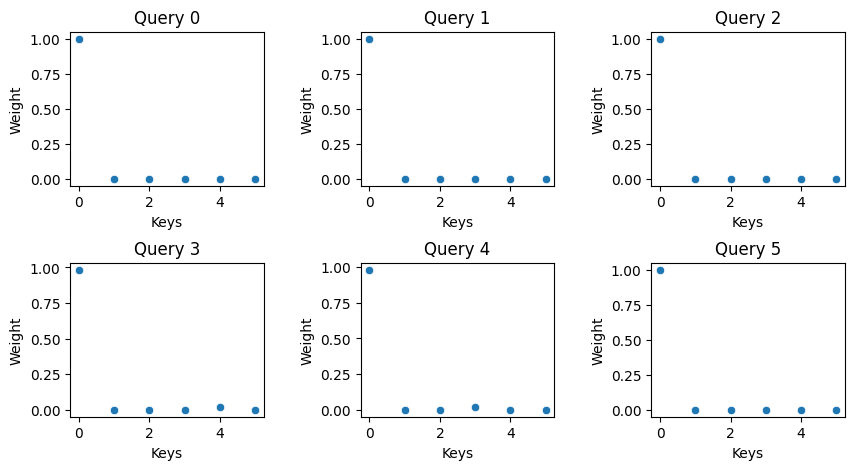

In [26]:
# Plot weights for each query
_, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,5), gridspec_kw={"wspace": 0.5, "hspace": 0.5})
for i in range(6):
    ax = axs[i//3][i%3]
    sns.scatterplot(x=np.arange(len(w[i])), y=w[i].detach(), ax=ax)
    ax.set_title(f"Query {i}")
    ax.set_xlabel(f"Keys")
    ax.set_ylabel(f"Weight")

## Attention Output

Now that we have the attention weights, we can apply them to the values. This will give us a weighted sum of contextual information. However, the answer is still in "value space". Before we combine them with the token embeddings, we'll project them back to "model space".

In [27]:
# Compute weighted combination of values
a = w @ v

a.shape

torch.Size([6, 768])

In [28]:
# Configure output projection
outputs = nn.Linear(
    in_features=config.d_model, 
    out_features=config.d_model,
)

# Load pre-trained state
load_state(outputs, "outputs")

In [29]:
# Project attention embeddings back to model space
a = outputs(a)

a.shape

torch.Size([6, 768])

## Multi-Head Attention

At this point, we've walked through the core SDPA algorithm step-by-step. However, we're not quite done. Vaswani et al. realized there are more than one set of relationships involved in transferring context across tokens. A single application of SDPA would effectively water these down by averaging them together. The solution is to apply SDPA multiple times on separate query, key, and value embeddings. Each of these is referred to as an "attention head". Each head is isolated, leaving it free to learn distinct relational structures.

In [30]:
def split_heads(x):
    return x.view(-1, config.n_heads, config.d_head).transpose(-3, -2)

def combine_heads(x):
    return x.transpose(-3, -2).contiguous().view(-1, int(config.n_heads * config.d_head))

In [31]:
# Render query, key, value dimensions before we split
q.shape, k.shape, v.shape

(torch.Size([6, 768]), torch.Size([6, 768]), torch.Size([6, 768]))

In [32]:
# Split queries, keys, values into separate heads
q = split_heads(q)
k = split_heads(k)
v = split_heads(v)

q.shape, k.shape, v.shape

(torch.Size([12, 6, 64]), torch.Size([12, 6, 64]), torch.Size([12, 6, 64]))

We can see that the queries, keys, and values have been split into 12 heads. Each of the original 768-element query, key, and value embeddings is now 64 elements long.

Next, let's recompute the attention embeddings.

In [33]:
# Compute attention for all heads in parallel
a = softmax(q @ k.transpose(-2, -1) / np.sqrt(config.d_head), dim=-1) @ v

a.shape

torch.Size([12, 6, 64])

While the attention code is the same, you can see the attention values are still split into heads. Next, we'll recombine them before applying the final output projection.

In [34]:
# Recombine heads
a = combine_heads(a)

a.shape

torch.Size([6, 768])

In [35]:
# Project attention embeddings back to model space
a = outputs(a)

a.shape

torch.Size([6, 768])

## Add and Normalize

Before we get to the FFN, we combine the attention embeddings with input embeddings the same way we combined the value and position embeddings.

In [36]:
# Configure attention normalization
normalize_attention = nn.LayerNorm(
    normalized_shape=config.d_model, 
    eps=1e-12,
)

# Load pre-trained state
load_state(normalize_attention, "normalize_attention")

In [37]:
# Combine attention with input embeddings
y = normalize_attention(x + a)

y.shape

torch.Size([6, 768])

## FFN

The FFN block is a straightforward fully connected multi-layer perceptron.

In [38]:
# Configure FFN
ffn = nn.Sequential(
    nn.Linear(in_features=config.d_model, out_features=config.d_ffn),
    nn.GELU(),
    nn.Linear(in_features=config.d_ffn, out_features=config.d_model),
)

# Load pre-trained state
load_state(ffn, "ffn")

In [39]:
# Transform attention outputs
f = ffn(y)

f.shape

torch.Size([6, 768])

## Add and Normalize

Next, we combine the transformed embeddings with the attention embeddings.

In [40]:
# Configure attention normalization
normalize_ffn = nn.LayerNorm(
    normalized_shape=config.d_model,
    eps=1e-12,
)

# Load pre-trained state
load_state(normalize_ffn, "normalize_ffn")

In [41]:
z = normalize_ffn(y + f)

z.shape

torch.Size([6, 768])

Quick recap... We just finished going through a single Transformer layer. Given input embeddings $X$, we calculated and added attention embeddings to get $Y$, and then calculated and added transformed embeddings to get $Z$.

$$
\begin{align}
Y &= Normalize(X + Attention(X)) \\
Z &= Normalize(Y + FFN(Y))
\end{align}
$$

## Stacking the Layers

Next, we combine all of the steps and repeat for each layer in the stack. While you would normally create a stack of torch modules, instead we run the layers in a loop to make it easier to see what's happening.

In [42]:
# Initialize loop w/ initial input embeddings
z_i = x

# Apply layer logic in a loop
for layer in range(config.n_layers):
    
    # Use previous layer's outputs as inputs
    x_i = z_i

    # Load pre-trained state for layer
    load_pretrained_state(layer)

    #
    # Attention
    #
    
    # Project x_i to query, key, and value spaces
    q_i = queries(x_i)
    k_i = keys(x_i)
    v_i = values(x_i)
    
    # Split q, k, v into separate attention heads
    q_i = split_heads(q_i)
    k_i = split_heads(k_i)
    v_i = split_heads(v_i)

    # Compute attention for all heads in parallel
    w_i = softmax(
        q_i @ k_i.transpose(-2, -1) / np.sqrt(config.d_head), 
        dim=-1,
    )
    a_i = w_i @ v_i
    
    # Recombine attention heads
    a_i = combine_heads(a_i)
    
    # Project attention embeddings back to model space
    a_i = outputs(a_i)

    # Add and normalize
    y_i = normalize_attention(x_i + a_i)

    #
    # FFN
    #

    # Transform attention
    f_i = ffn(y_i)

    # Add and normalize
    z_i = normalize_ffn(y_i + f_i)

# Save outputs from last layer
z = z_i

In [43]:
z

tensor([[ 3.6173e-01, -1.3168e-01,  3.5340e-02,  ...,  4.4015e-01,
          1.0666e+00, -1.9293e-01],
        [ 7.3341e-01,  4.9823e-02, -1.7590e-02,  ...,  5.0063e-01,
          1.1480e+00, -1.2997e-01],
        [ 1.1230e+00,  2.7603e-01,  3.2096e-01,  ...,  1.8820e-01,
          1.0586e+00, -1.2496e-01],
        [ 4.8728e-01,  1.4863e-02,  4.2930e-01,  ...,  4.8993e-01,
          7.9435e-01,  1.2331e-01],
        [ 1.0595e-03, -1.4508e-01,  2.8892e-01,  ...,  5.5342e-01,
          7.9370e-01, -9.0899e-02],
        [ 1.1021e+00,  8.6115e-02,  5.7461e-01,  ...,  6.8800e-01,
          5.6345e-01, -6.6278e-01]], grad_fn=<NativeLayerNormBackward0>)

In [44]:
# Sanity check
hiddens = transformer.model.distilbert(input_ids=batch.input_ids.to(device)).last_hidden_state.squeeze().to("cpu")
assert torch.allclose(z, hiddens, atol=1e-5)

# Head

As the final stage in the Transformer pipeline, Head maps the contextualized embeddings to task-specific predictions. In our case, the Head stage is responsible for turning the contextualized embeddings into a binary classifier that predicts whether the original text contains positive or negative sentiments. This sounds like a straightforward neural network output layer until you realize that instead of one set of features, we have a sequence of features. And the length of the sequence is arbitrary. How do you connect an arbitrary length sequence of feature vectors to an output layer?

The trick is hiding in our contextualized embeddings. Each input embedding represents a single token in isolation. But the output embeddings have been infused with information from all of the tokens. This is why it's common practice to simply take the first output embedding and drop the rest. The first embedding represents the start of sequence marker `[CLS]`. Since the `[CLS]` marker token is added to every sequence, the first *input* embedding is always the same. In contrast, the first *output* embedding uniquely represents this specific sequence.

If we take the first output embedding to represent the entire sequence, then we have a single feature vector that's easy to connect to any task-specific output layer we need.

In [45]:
# Use [CLS] embedding to represent the entire sequence
features = z[0]

features.shape

torch.Size([768])

In [46]:
# Configure classifier head
classifier = nn.Sequential(
    nn.Linear(in_features=config.d_model, out_features=config.d_model),
    nn.ReLU(),
    nn.Linear(in_features=config.d_model, out_features=config.n_labels),
)

# Load pre-trained state
load_state(classifier, "classifier")

In [47]:
# Classify features
prediction1 = torch.softmax(classifier(features), dim=-1)[1].item()
prediction1

0.9998118281364441

In [48]:
# Verify custom results match off-the-shelf ones
prediction2 = transformer("I love ice cream")[0]["score"]
prediction2

0.9998118281364441

In [49]:
assert prediction1 == approx(prediction2)

# Recap

We did it! We dissected an off-the-shelf, production-grade Transformer model, cataloged all the parts, and reassembled everything, tracing a single inference from the raw text "I love ice cream" to a positive sentiment prediction of `0.99`. Not only did we get the same positive prediction, we got the exact same answer as Hugging Face's production PyTorch code! That should give you confidence at least that we didn't leave any steps out.

I hope you learned something about Transformers. In the very least, I hope they're a little less intimidating. Go take something else apart!

# References

Bengio, Yoshua, Réjean Ducharme, and Pascal Vincent. “A Neural Probabilistic Language Model.” In Advances in Neural Information Processing Systems, Vol. 13. MIT Press, 2000. <https://proceedings.neurips.cc/paper_files/paper/2000/hash/728f206c2a01bf572b5940d7d9a8fa4c-Abstract.html>.

Devlin, Jacob, Ming-Wei Chang, Kenton Lee, and Kristina Toutanova. “BERT: Pre-Training of Deep Bidirectional Transformers for Language Understanding.” arXiv, May 24, 2019. <https://doi.org/10.48550/arXiv.1810.04805>.

“Transformer Explainer: LLM Transformer Model Visually Explained.” Accessed August 29, 2024. <https://poloclub.github.io/transformer-explainer/>.

Vaswani, Ashish, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. “Attention Is All You Need.” arXiv, August 1, 2023. <https://doi.org/10.48550/arXiv.1706.03762>

Xu, Peng, Xiatian Zhu, and David A. Clifton. “Multimodal Learning with Transformers: A Survey.” arXiv, May 9, 2023. <https://doi.org/10.48550/arXiv.2206.06488>.